# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Imports

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
import pickle

# Specific functions import
from matplotlib.ticker import FormatStrFormatter
from skimage import exposure
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from imgaug import augmenters as iaa

# Plot in the notebook
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
# Load pickled data
training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# Some global data to be use along the notebook

# Read class names to title the images
df_sign_names = pd.read_csv('signnames.csv')
dict_sign_names = dict(zip(df_sign_names['ClassId'], df_sign_names['SignName']))
sign_classes = np.array(df_sign_names['ClassId'])

---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set:

In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
S_total = pd.Series(np.concatenate((y_train, y_valid, y_test), axis=0), dtype='str')
n_classes = len(S_total.unique())

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


There is no uniform distribution of examples among classes:

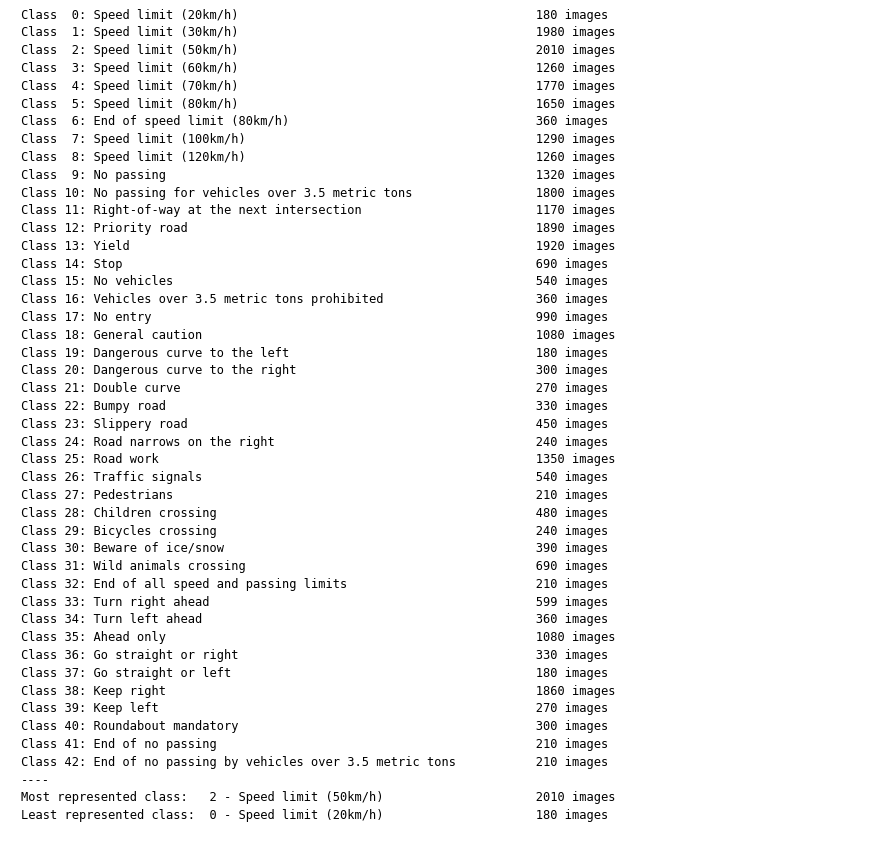

In [39]:
# Count train examples per class
min_class = (float('inf'), '')
max_class = (-float('inf'), '')

subplot_num = 46
subplot_counter = 1
fig = plt.figure(figsize=(15, 15))
for sign_class in sign_classes:
    
    sign_counter = np.sum(y_train == sign_class)
    min_class = min(min_class, (sign_counter, sign_class))
    max_class = max(max_class, (sign_counter, sign_class))
    
    txtplt = fig.add_subplot(subplot_num,1,subplot_counter)
    text = "Class {:2}: {:60} {:>d} images".format(sign_class, dict_sign_names[sign_class], sign_counter)
    plt.text(0, 0.5, text, fontsize = 12, fontname = 'monospace')
    txtplt.axis('off')
    subplot_counter += 1

txtplt = fig.add_subplot(subplot_num,1,subplot_counter)
plt.text(0, 0.5, '----', fontsize = 12, fontname = 'monospace')
txtplt.axis('off')
subplot_counter += 1

txtplt = fig.add_subplot(subplot_num,1,subplot_counter)
the_most = "Most represented class:  {:2} - {:40} {:>d} images".format(max_class[1], dict_sign_names[max_class[1]], max_class[0])
plt.text(0, 0.5, the_most, fontsize = 12, fontname = 'monospace')
txtplt.axis('off')
subplot_counter += 1

txtplt = fig.add_subplot(subplot_num,1,subplot_counter)
the_least = "Least represented class: {:2} - {:40} {:>d} images".format(min_class[1], dict_sign_names[min_class[1]], min_class[0])
plt.text(0, 0.5, the_least, fontsize = 12, fontname = 'monospace')
txtplt.axis('off')

fig.savefig('writeup-images/class_counter')

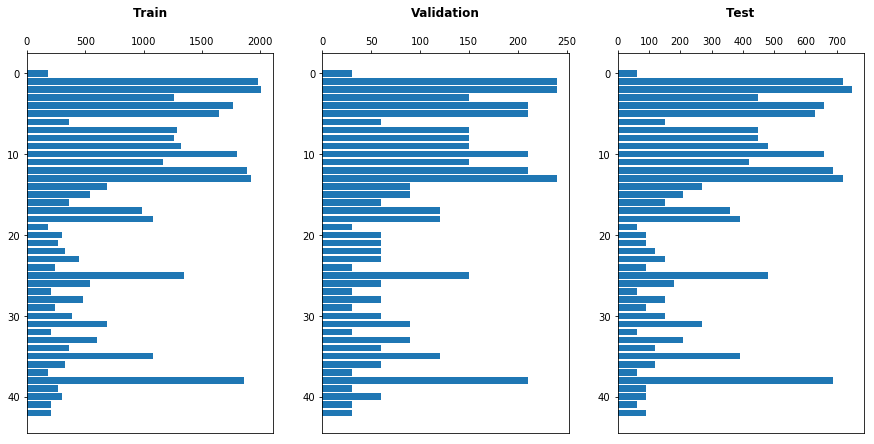

In [6]:
fig = plt.figure(figsize=(15, 7))
subplot_counter = 1
for data, title in zip([y_train, y_valid, y_test],['Train', 'Validation', 'Test']):
    unique, counts = np.unique(data, return_counts=True)
    sbplt = fig.add_subplot(1,3,subplot_counter)
    barplot = plt.barh(unique, counts)
    subplot_counter += 1
    sbplt.invert_yaxis()
    sbplt.xaxis.tick_top()
    sbplt.set_title(title, fontweight = 'bold', fontsize = 12, y = 1.08)
    sbplt.patch.set_visible(False)
    fig.savefig('writeup-images/label_distribution')

However, the distribution of examples among classes is similar in training, validation and test sets.

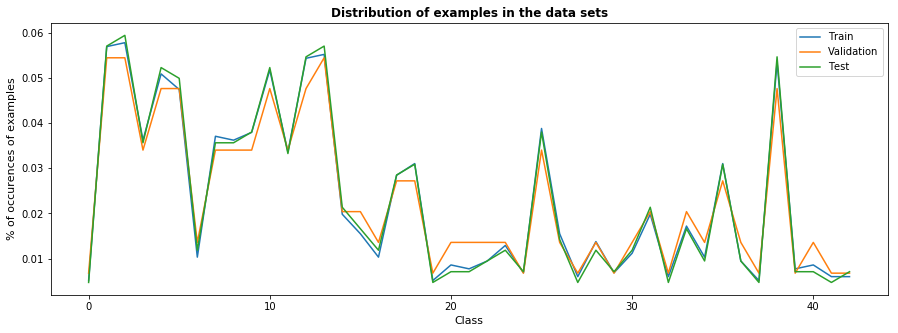

In [7]:
fig = plt.figure(figsize=(15, 5))
for data, title in zip([y_train, y_valid, y_test],['Train', 'Validation', 'Test']):
    unique, counts = np.unique(data, return_counts=True)
    plt.plot(unique, counts/len(data))
plt.xlabel('Class', fontsize = 11)
plt.ylabel('% of occurences of examples', fontsize = 11)
plt.title('Distribution of examples in the data sets', fontweight = 'bold', fontsize = 12)
plt.legend(['Train', 'Validation', 'Test'])
fig.savefig('writeup-images/label_distribution_2')

### Exploratory visualization of the dataset

In [57]:
# Helper functions to sample and print images

# Print set of images in n_columns
def print_images(data, labels, num_rows, num_cols, gray = False, figsize=(20, 45)):
    sample_size = num_rows * num_cols
    subplot_counter = 1
    fig = plt.figure(figsize=figsize)
    for image, label in zip(data, labels):
        img_el = fig.add_subplot(sample_size,num_cols,subplot_counter)
        subplot_counter += 1
        if gray:
            imgplot = plt.imshow(image.squeeze(), cmap='gray_r')
        else:
            imgplot = plt.imshow(image)
        img_el.axis('off')
        img_el.set_title(str(label)+' : '+dict_sign_names[label], fontsize=10)

def print_stripes(data, labels, sample_size, sign_classes,
                  print_conv = False, conv_data = None,
                  img_type = 'Sample-original', save_fig = False,  save_dir = 'writeup-images'):

    height = 1
    if print_conv:
        height = 2    
    
    for sign_class in sign_classes[:]:
        # Get n random images
        img_idx = np.random.choice(np.argwhere( labels == sign_class).flatten(), sample_size).astype('int')
        img_sample = data[img_idx]
        if print_conv:
            conv_img_sample = conv_data[img_idx]

        # Class title
        title = "Class {:2}: {:60}".format(sign_class, dict_sign_names[sign_class])

        # Print images
        fig = plt.figure(figsize = (9,2))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
        for idx in range(sample_size):
            imgplt = fig.add_subplot(height, sample_size, idx+1)
            imgplt.imshow(img_sample[idx])
            imgplt.axis('off')
            if idx == 0:
                imgplt.set_title(title, fontsize = 12, y = 1.08, loc='left', fontname = 'monospace')
            if print_conv:
                imgplt = fig.add_subplot(height, sample_size, sample_size+idx+1)
                imgplt.imshow(conv_img_sample[idx].squeeze(), cmap='gray_r')
                imgplt.axis('off')
            
        if save_fig:
            plt.savefig('{}/{}-{}'.format(save_dir, img_type, sign_class))      
        
# Funcion to sample n training examples from each class
def get_sample_fix_class(data, labels, sign_classes, num_ex_per_class):
    # Select images num_ex_per_class per class
    sample_idx = np.array([], dtype = 'int')
    for sign_class in sign_classes:
        idx = np.random.choice(np.argwhere( labels == sign_class).flatten(), num_ex_per_class).astype('int')
        sample_idx = np.concatenate((sample_idx, idx),axis=0)
    return data[sample_idx], labels[sample_idx]

# Funciont to sample n training examples in same class distribution as original data sets
def get_sample_keep_dist(data, labels, sign_classes, num_total_ex):
    
    unique, counts = np.unique(labels, return_counts=True)
    reduced_distrib = np.maximum(1.0, counts * num_total_ex / len(data)).astype('int')
    class_examples = dict(zip(unique, reduced_distrib))
    
    sample_idx = np.array([], dtype = 'int')
    for sign_class in sign_classes:
        idx = np.random.choice(np.argwhere( labels == sign_class).flatten(), class_examples[sign_class]).astype('int')
        sample_idx = np.concatenate((sample_idx, idx),axis=0)
        
    return data[sample_idx], labels[sample_idx]

Print a stripe of 10 images of each class

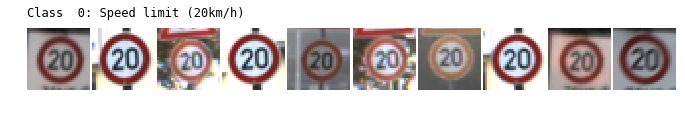

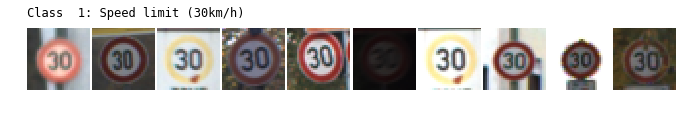

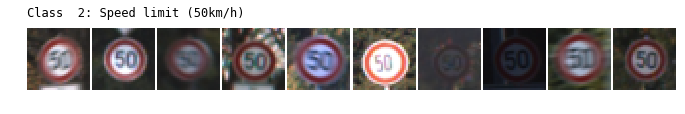

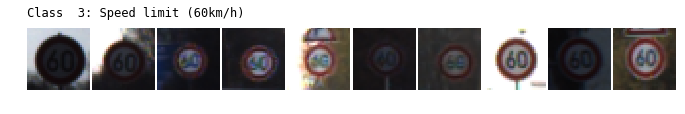

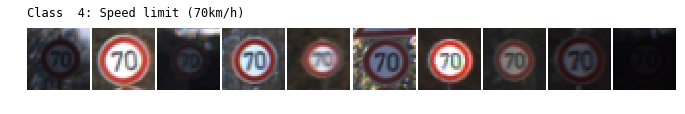

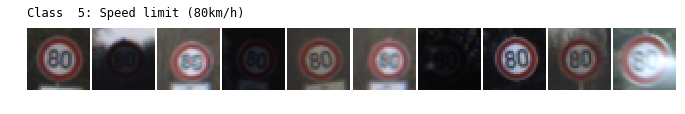

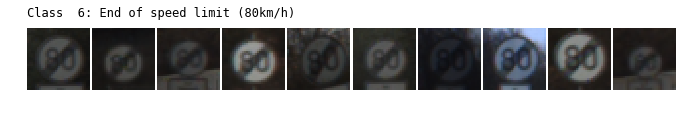

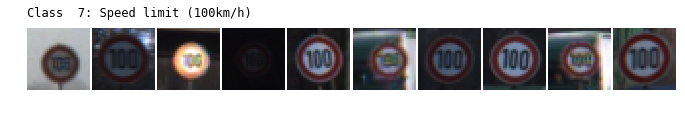

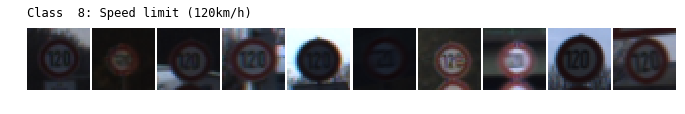

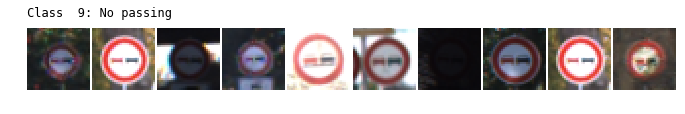

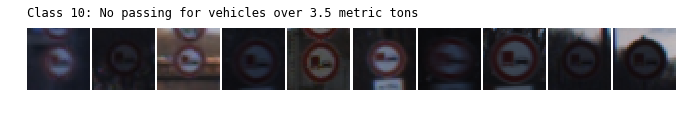

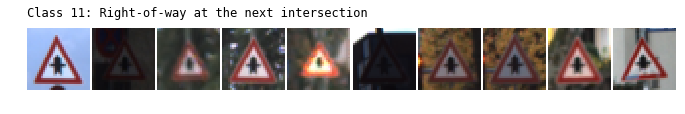

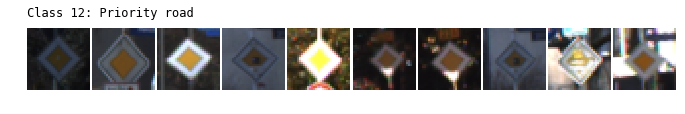

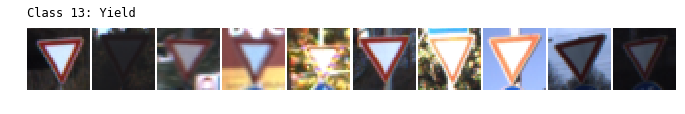

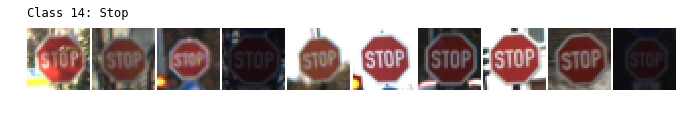

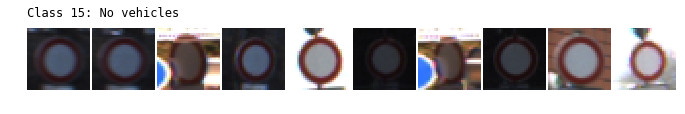

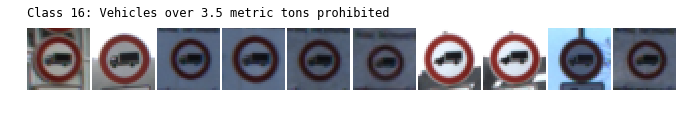

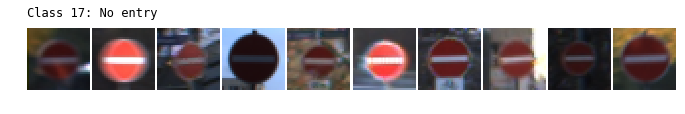

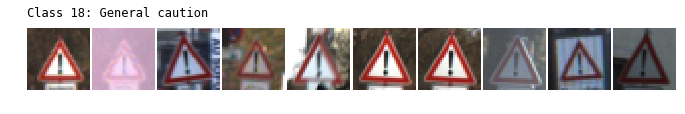

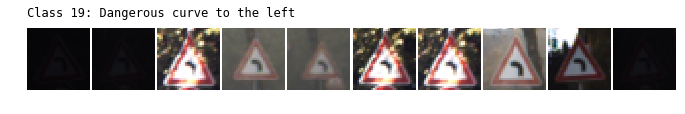

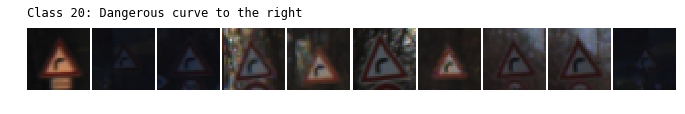

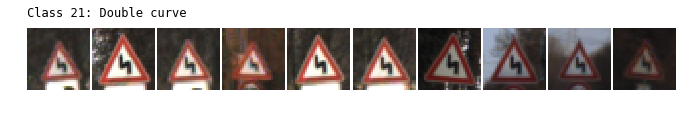

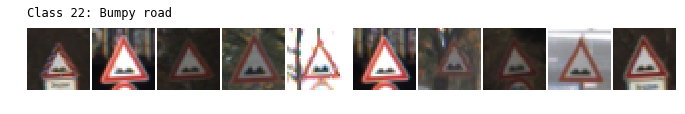

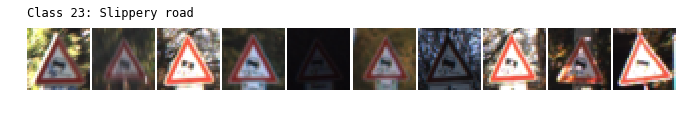

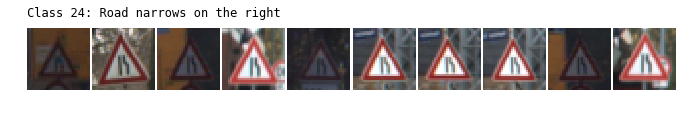

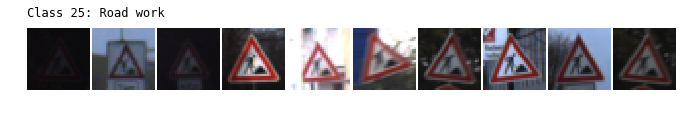

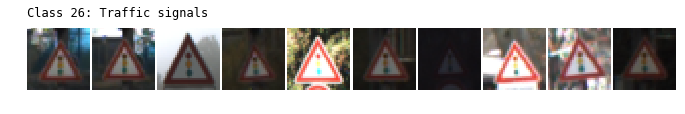

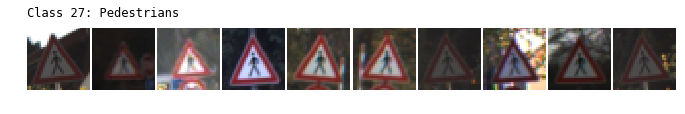

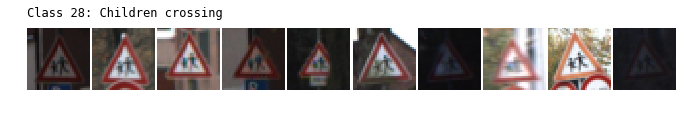

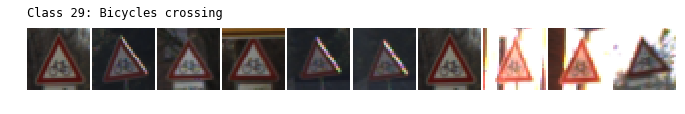

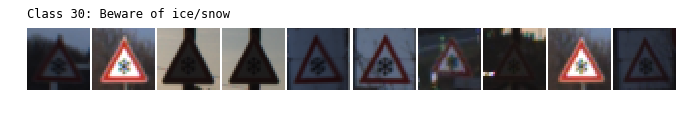

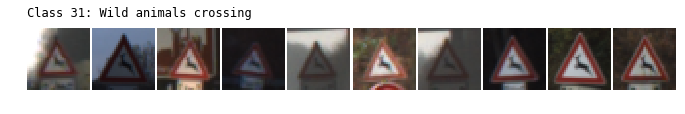

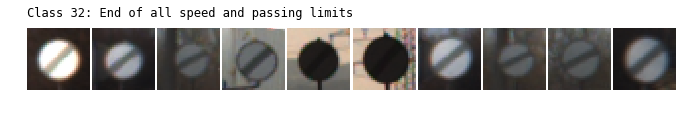

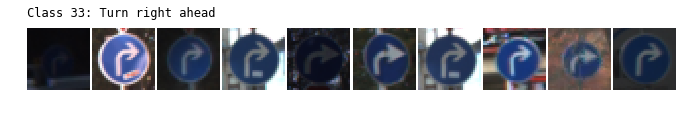

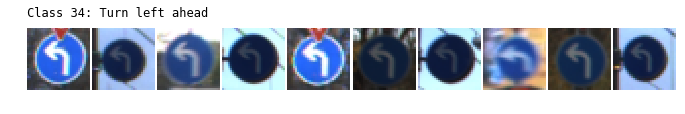

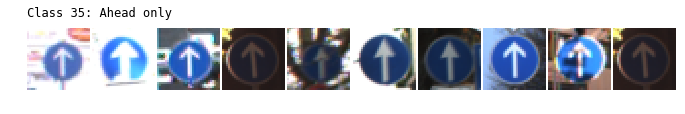

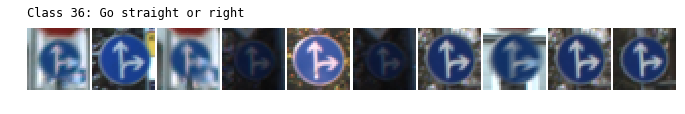

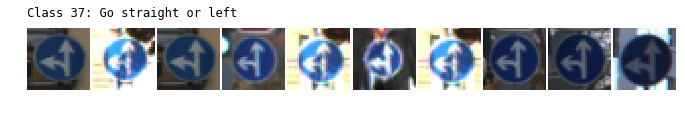

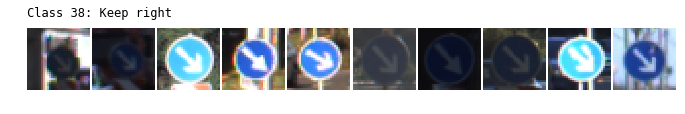

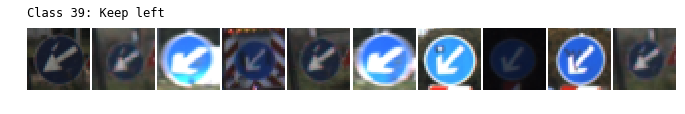

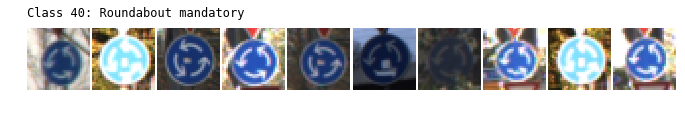

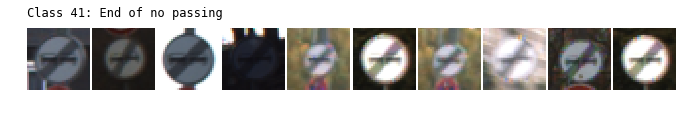

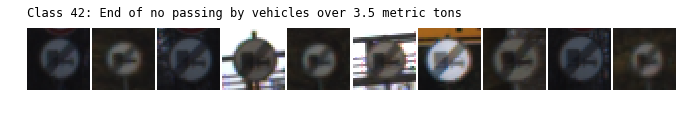

In [55]:
# Set seet for stable results
np.random.seed(2)
plt.rcParams.update({'figure.max_open_warning': 50}) #Avoid warnong for too many figures
print_stripes(X_train, y_train, 10, sign_classes, save_fig = True)

----

## Step 2: Design and Test Model Architecture

The model architecture will be based in LeNet model adding dropout and L2 regularization, image pre-processing and data augmentation.

### Pre-process the Data Set (normalization, grayscale, etc.)

Preprocess data applying 3 techniques:
- Intensity adjustment
- Convert to grayscale
- Normalize the images (using image / 255)

In [10]:
# Pre-processing function
def pre_process_data(data):
    conv_data = 0.299*data[:, :, :, 0] + 0.587*data[:, :, :, 1] + 0.114*data[:, :, :, 2]
    conv_data = conv_data/ 255.
    conv_data = np.array([exposure.equalize_adapthist(image) for image in conv_data])
    return np.expand_dims(conv_data, axis=3)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


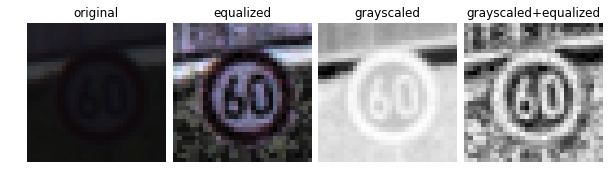

In [48]:
# Pre-processing pipeline:
np.random.seed(3)
sample_image = X_train[np.random.choice(n_train,1)][0]
sample_grey = 0.299*sample_image[:, :, 0] + 0.587*sample_image[:, :, 1] + 0.114*sample_image[:, :, 2]
sample_eq = exposure.equalize_adapthist(sample_image)
sample_norm = sample_grey/255
sample_grey_eq = exposure.equalize_adapthist(sample_norm)

fig = plt.figure(figsize = (8,3))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

imgplt = fig.add_subplot(1, 4, 1)
imgplt.imshow(sample_image)
imgplt.axis('off')
imgplt.set_title('original')

imgplt = fig.add_subplot(1, 4, 2)
imgplt.imshow(sample_eq.squeeze(), cmap='gray_r')
imgplt.axis('off')
imgplt.set_title('equalized')

imgplt = fig.add_subplot(1, 4, 3)
imgplt.imshow(sample_grey.squeeze(), cmap='gray_r')
imgplt.axis('off')
imgplt.set_title('grayscaled')

imgplt = fig.add_subplot(1, 4, 4)
imgplt.imshow(sample_grey_eq.squeeze(), cmap='gray_r')
imgplt.axis('off')
imgplt.set_title('grayscaled+equalized')

fig.savefig('writeup-images/preprocessing-pipeline')

In [49]:
# Preprocess operation takes long time, so first time we'll convert and save it and then just load from file:
conv_training_file = "traffic-signs-data/conv_train.p"
conv_valid_file = "traffic-signs-data/conv_valid.p"
conv_test_file = "traffic-signs-data/conv_test.p"

# Upload or convert training data
try:
    with open(conv_training_file, mode='rb') as f:
        X_conv_train = pickle.load(f)
    print("Upload converted training data")
except OSError as err:
    print("Converting training data")
    X_conv_train = pre_process_data(X_train)
    pickle.dump( X_conv_train, open( conv_training_file, "wb" ) )

# Upload or convert validation data
try:
    with open(conv_valid_file, mode='rb') as f:
        X_conv_valid = pickle.load(f)
    print("Upload converted validation data")
except OSError as err:
    print("Converting validation data")
    X_conv_valid = pre_process_data(X_valid)
    pickle.dump( X_conv_valid, open( conv_valid_file, "wb" ) )
    
# Upload or convert test data
try:
    with open(conv_test_file, mode='rb') as f:
        X_conv_test = pickle.load(f)
    print("Upload converted test data")
except OSError as err:
    X_conv_test = pre_process_data(X_test)
    print("Converting test data")
    pickle.dump( X_conv_test, open( conv_test_file, "wb" ) )

Upload converted training data
Upload converted validation data
Upload converted test data


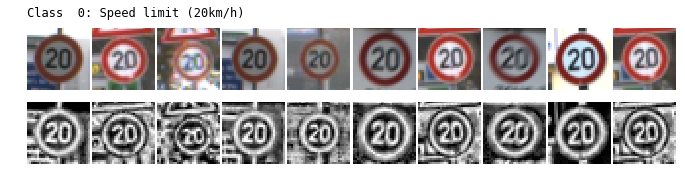

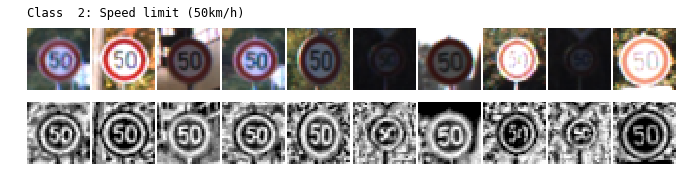

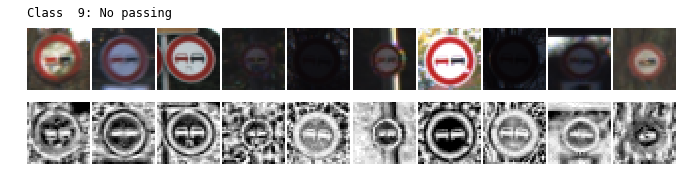

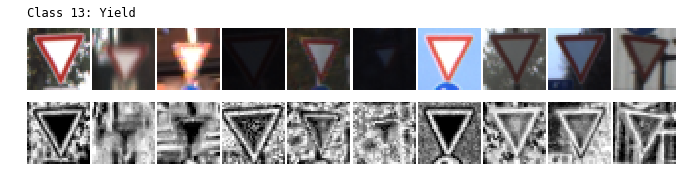

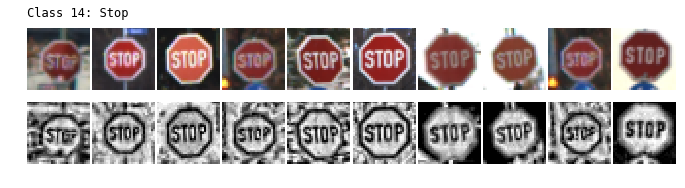

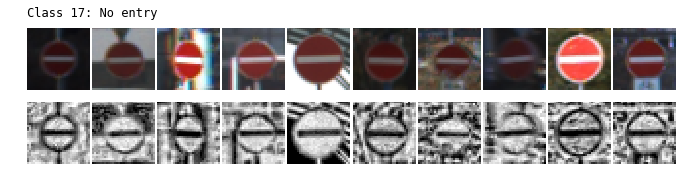

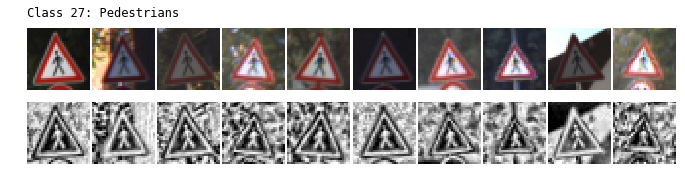

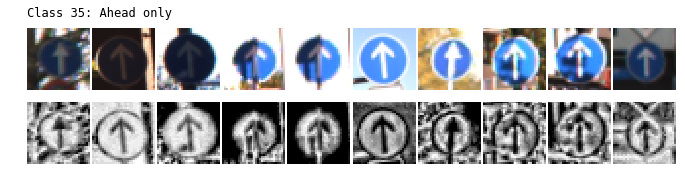

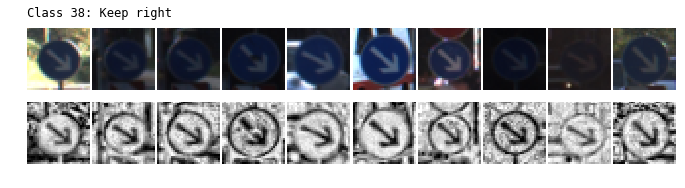

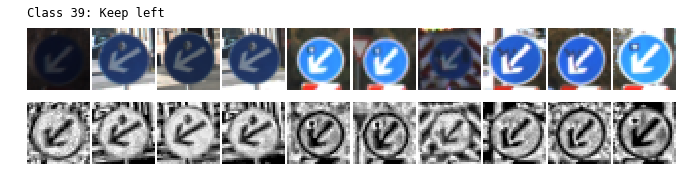

In [58]:
# Test preprocessing
# x_sample, y_sample = get_sample_fix_class(X_conv_train, y_train, sign_classes, 1)
# print_images(x_sample, y_sample, 3, 5, gray = True)
np.random.seed(2)
print_stripes(X_train, y_train, 10, sorted(np.random.choice(sign_classes,10, replace=False)),
              print_conv = True, conv_data = X_conv_train,
              img_type = 'Sample-converted', save_fig = True,  save_dir = 'writeup-images')

### Model Architecture

In [ ]:
# Wrappers to simplify CNN definition
def conv2d(x, W, b, stride = 1, padding = 'VALID'):
    temp = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    return tf.nn.bias_add(temp, b)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

In [ ]:
# CNN model
def ConvNet(x, weights, biases, keep_prob):   

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)

    # Apply dropout
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(fc0, weights['wf1']), biases['bf1']) 
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Apply dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)    
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wf2']), biases['bf2']) 
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.  
    logits = tf.add(tf.matmul(fc2, weights['wf_out']), biases['bf_out'])
    
    return logits, conv1, conv2, fc1, fc2

In [ ]:
# Dicts for layers weight & bias
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# Weights
weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape = (5, 5, 1, 6), mean = mu, stddev = sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma)),
    'wf1': tf.Variable(tf.truncated_normal(shape = (400, 120), mean = mu, stddev = sigma)),
    'wf2': tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma)),
    'wf_out': tf.Variable(tf.truncated_normal(shape = (84, 43), mean = mu, stddev = sigma))    
}

# Biases
biases = {
    'bc1': tf.Variable(tf.zeros(6)),
    'bc2': tf.Variable(tf.zeros(16)),
    'bf1': tf.Variable(tf.zeros(120)),
    'bf2': tf.Variable(tf.zeros(84)),
    'bf_out': tf.Variable(tf.zeros(43))
}

In [ ]:
# Graph input & training variables
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)
beta = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, 43)

In [ ]:
# Construct model
logits, conv1, conv2, fc1, fc2 = ConvNet(x, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

In [ ]:
# Define loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
# Loss function with L2 Regularization with beta=0.01
regularizers = tf.nn.l2_loss(weights['wf1']) + tf.nn.l2_loss(weights['wf2']) + tf.nn.l2_loss(weights['wf_out'])
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation + beta * regularizers)

In [ ]:
# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
# Reduce data sets for simple trainings (no reduction if n_train / n_validation / n_test are used)
n_mini_train = n_train
n_mini_valid = n_validation
n_mini_test = n_test

# Get the reduced data keeping class distribution of original data set
X_mini_train, y_mini_train = get_sample_keep_dist(X_conv_train, y_train, sign_classes, n_mini_train)
X_mini_valid, y_mini_valid = get_sample_keep_dist(X_conv_valid, y_valid, sign_classes, n_mini_valid)
X_mini_test, y_mini_test = get_sample_keep_dist(X_conv_test, y_test, sign_classes, n_mini_test)

In [ ]:
# Training parameters
epochs = 25
batch_size = 128
exp_lrate_decay = 0.88
base_learning_rate = 0.005
dropout = 0.65 # Dropout, probability to keep units
beta_reg = 0.0001
print_interval = 50

In [ ]:
epoch_no = []
loss_data = []
acc_data = []
batch_counter = 0

# Data to train and validate
training_data, training_labels = X_mini_train, y_mini_train
valid_data, valid_labels = X_mini_valid, y_mini_valid

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(training_data)
    
    # For big training data getting accuracy and loss in a single pass
    # consumes too much memory so we calculate it in batch
    def get_accuracy_and_loss(data, labels):
        loss = 0
        acc = 0
        num_examples = len(data)
        for offset in range(0, num_examples, batch_size):
            end = min(offset + batch_size, num_examples)
            batch_x, batch_y = data[offset:end], labels[offset:end]
            batch_loss, batch_acc = sess.run([loss_operation, accuracy_operation], 
                                             feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})    
            loss += batch_loss * (end - offset)
            acc += 100 * batch_acc * (end - offset)
        return loss / num_examples, acc / num_examples    
    
    # Training code
    print('Training model\n')
    for i in range(epochs):
        
        training_data, training_labels = shuffle(training_data, training_labels)
        l_rate = base_learning_rate * exp_lrate_decay**i
        
        for offset in range(0, num_examples, batch_size):
            end = min(offset + batch_size, num_examples)
            batch_x, batch_y = training_data[offset:end], training_labels[offset:end]
            sess.run(training_operation,
                     feed_dict={x: batch_x, y: batch_y, rate:l_rate, keep_prob: dropout, beta: beta_reg})
            
            # Get accuracy and loss at certain intervals
            if batch_counter%print_interval == 0:
                tr_loss, tr_acc = get_accuracy_and_loss(training_data, training_labels)
                vl_loss, vl_acc = get_accuracy_and_loss(valid_data, valid_labels)    
                loss_data.append((tr_loss, vl_loss))
                acc_data.append((tr_acc, vl_acc))
                epoch_no.append(i + end / num_examples)
            batch_counter += 1
        
        # Print evolution
        print("EPOCH {} ...".format(i+1))
        tr_loss, tr_acc = get_accuracy_and_loss(training_data, training_labels)
        vl_loss, vl_acc = get_accuracy_and_loss(valid_data, valid_labels) 
        print("Training Loss\t= {:.4f}\tTraining Accuracy\t= {:.2f}%".format(tr_loss, tr_acc))
        print("Validation Loss\t= {:.4f}\tValidation Accuracy\t= {:.2f}%".format(vl_loss, vl_acc))
        print()
        if tr_acc > 99.9:
            break

    saver.save(sess, './saved-model/german_traffic_signs')
    print("Model saved")

In [ ]:
## Print loss and accuracy graph
fig = plt.figure(figsize=(15, 4))

# Loss plot
loss_plt = fig.add_subplot(1,2,1)
line1, = loss_plt.plot(epoch_no, [loss[0] for loss in loss_data], linewidth=2, label='Training loss')
line2, = loss_plt.plot(epoch_no, [loss[1] for loss in loss_data], linewidth=2, label='Validation loss')
loss_plt.legend(loc='upper right')
loss_plt.set_title("Loss .vs. epochs", fontweight = 'bold', fontsize = 12)
loss_plt.xaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.xlabel('Batches processed', fontsize = 11)
plt.ylabel('Loss', fontsize = 11)

# Accuracy plot
loss_plt = fig.add_subplot(1,2,2)
line1, = loss_plt.plot(epoch_no, [acc[0] for acc in acc_data], linewidth=2, label='Training accuracy')
line2, = loss_plt.plot(epoch_no, [acc[1] for acc in acc_data], linewidth=2, label='Validation accuracy')
loss_plt.legend(loc='lower right')
loss_plt.set_title("Accuracy .vs. epochs", fontweight = 'bold', fontsize = 12)
loss_plt.xaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.xlabel('Batches processed', fontsize = 11)
plt.ylabel('Accuracy', fontsize = 11)

plt.savefig('writeup-images/loss_acc_graph')

In [ ]:
# Test accuracy
with tf.Session() as sess:   
    saver.restore(sess, './saved-model/german_traffic_signs') #'./german_traffic_signs')
    test_acc = sess.run(accuracy_operation, feed_dict={x: X_mini_valid, y: y_mini_valid, keep_prob: 1.0})  
print('Test accuracy: {:.2f}%'.format(test_acc*100))

---

## Step 3: Test a Model on New Images

### Load and Output the Images

In [ ]:
### Load new test images and plot them here.
X_new_test = []
y_new_test = np.array([3, 4, 7, 13, 30, 17, 14, 27, 1, 18, 11, 38, 14, 25]) # Label for each image
for file in sorted(os.listdir("new-examples")):
    if file[0] == '.': continue # avoid syste files
    image = cv2.imread(os.path.join("new-examples", file))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    new_image = cv2.resize(image, (32,32))
    X_new_test.append(new_image)
X_new_test = np.array(X_new_test)
print_images(X_new_test, y_new_test, 3, 5, figsize=(16,35))
plt.savefig('writeup-images/new_images')

### Pre-process images

In [ ]:
# Print again after preprocessing
X_new_gray = pre_process_data(X_new_test)
print_images(X_new_gray, y_new_test, 3, 5, gray = True, figsize=(16,35))
plt.savefig('writeup-images/new_conv_images')

### Predict the Sign Type for Each Image

In [ ]:
# Run session to get predictions
with tf.Session() as sess:
    saver.restore(sess, './saved-model/german_traffic_signs') #'./german_traffic_signs')
    pred_signs = sess.run(tf.argmax(logits, 1) , feed_dict={x: X_new_gray, y: y_new_test, keep_prob: 1.0})
    new_img_acc = sess.run(accuracy_operation , feed_dict={x: X_new_gray, y: y_new_test, keep_prob: 1.0})    

# Print images + predictions
subplot_counter = 1
fig = plt.figure(figsize=(4, 60))
for image, label, pred_sign in zip(X_new_test, y_new_test, pred_signs):
    img_el = fig.add_subplot(28,2,subplot_counter)
    subplot_counter += 1
    imgplot = plt.imshow(image)
    img_el.axis('off')
    #img_el.set_title(str(label)+' : '+dict_sign_names[label]+
    #                '\t'+str(pred_sign)+' : '+dict_sign_names[pred_sign])
    img_el.set_title("")
    
    text_el = fig.add_subplot(28,2,subplot_counter)
    if label == pred_sign:
        textplot = plt.text(0, 4, r'$\checkmark$', fontsize=40, color='green')
    else:
        textplot = plt.text(0, 4, 'X', fontsize=30, color='red')
    textplot = plt.text(0, 3, "LABEL:")
    textplot = plt.text(0, 2, str(label)+' : '+dict_sign_names[label])
    textplot = plt.text(0, 1, "PREDICTION:")
    textplot = plt.text(0, 0, str(pred_sign)+' : '+dict_sign_names[pred_sign])
    plt.ylim(-1, 6)
    plt.xlim(-0.2, 0.6)
    plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
    subplot_counter += 1
plt.savefig('writeup-images/new_images_predictions')

# Print images + class and prediction
def print_images(data, labels, num_rows, num_cols, gray = False):
    sample_size = num_rows * num_cols

### Analyze Performance

In [ ]:
print("New images prediction accuracy = {:.2f}%".format(new_img_acc*100))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
# Run session to get predictions
with tf.Session() as sess:
    saver.restore(sess, './saved-model/german_traffic_signs') #'./german_traffic_signs')
    preds = sess.run(prediction, feed_dict={x: X_new_gray, keep_prob: 1})
    top_pred = sess.run(tf.nn.top_k(preds, k=5))

# Print images with predictions
subplot_counter = 1
fig = plt.figure(figsize=(8, 60))
for image, predictions, idx in zip(X_new_test, top_pred.values, top_pred.indices):
    img_el = fig.add_subplot(28,2,subplot_counter)
    subplot_counter += 1
    img_plot = plt.imshow(image)
    img_el.axis('off')

    bar_el = fig.add_subplot(28,2,subplot_counter)
    subplot_counter += 1
    barplot = plt.barh(range(5), predictions)
    #bar_el.set_title(title)
    bar_el.patch.set_visible(False)
    bar_el.invert_yaxis()
    bar_el.axis('off')
    bar_el.set_yticklabels(idx)
    for i, v in enumerate(zip(predictions, idx)):
        value, index = v
        bar_el.text(value+0.05, i+.15, '{:.2f}% - {}'.format(value*100, dict_sign_names[index]))
        
plt.savefig('writeup-images/new_images_top_predictions')

### Training with data augmentation

In [ ]:
# Data augmentation
seq_scale = iaa.Sequential([iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)})])
seq_rotate = iaa.Sequential([iaa.Affine(rotate=(-30, 30))]) # rotate by -45 to +45 degrees
seq_shear = iaa.Sequential([iaa.Affine(shear=(-20, 20))])# shear by -16 to +16 degrees

X_conv_scale_train = seq_scale.augment_images(X_conv_train)
X_conv_rotate_train = seq_rotate.augment_images(X_conv_train)
X_conv_shear_train = seq_shear.augment_images(X_conv_train)

In [ ]:
X_conv_aug_train = np.concatenate((X_conv_train,X_conv_scale_train,X_conv_rotate_train,X_conv_shear_train))
y_aug_train = np.concatenate((y_train,y_train,y_train,y_train))

In [ ]:
# Sample of augmentation techniques:
sample_size = 10
stripe_number = 5
sample_idx = np.random.choice(y_train.shape[0], sample_size)
stripes =  [X_train[sample_idx], X_conv_train[sample_idx], X_conv_scale_train[sample_idx],
            X_conv_rotate_train[sample_idx], X_conv_shear_train[sample_idx]]
row = 0
fig = plt.figure(figsize = (sample_size+2, stripe_number))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for stripe, title in zip(stripes, ['Original', 'Preprocessed', 'Scaled', 'Rotated', 'Sheared']):
    col = 1
    for image in stripe:        
        imgplt = fig.add_subplot(stripe_number, (sample_size+1), (sample_size+1)*row+col)
        if col == 1:
            plt.text(0, 0.5, title, fontsize=12)
        else:
            imgplt.imshow(image.squeeze(), cmap='gray_r')
        imgplt.axis('off')
        col += 1
    row += 1

In [ ]:
# Training parameters
epochs = 25
batch_size = 128
exp_lrate_decay = 0.88
base_learning_rate = 0.0025
dropout = 0.8 # Dropout, probability to keep units
beta_reg = 0.0
print_interval = 500

In [ ]:
epoch_no = []
loss_data = []
acc_data = []
batch_counter = 0

# Data to train and validate
training_data, training_labels = X_conv_aug_train, y_aug_train
valid_data, valid_labels = X_mini_valid, y_mini_valid

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(training_data)
    
    # For big training data getting accuracy and loss in a single pass
    # consumes too much memory so we calculate it in batch
    def get_accuracy_and_loss(data, labels):
        loss = 0
        acc = 0
        num_examples = len(data)
        for offset in range(0, num_examples, batch_size):
            end = min(offset + batch_size, num_examples)
            batch_x, batch_y = data[offset:end], labels[offset:end]
            batch_loss, batch_acc = sess.run([loss_operation, accuracy_operation], 
                                             feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})    
            loss += batch_loss * (end - offset)
            acc += 100 * batch_acc * (end - offset)
        return loss / num_examples, acc / num_examples    
    
    # Training code
    print('Training model\n')
    for i in range(epochs):
        
        training_data, training_labels = shuffle(training_data, training_labels)
        l_rate = base_learning_rate * exp_lrate_decay**i
        
        for offset in range(0, num_examples, batch_size):
            end = min(offset + batch_size, num_examples)
            batch_x, batch_y = training_data[offset:end], training_labels[offset:end]
            sess.run(training_operation,
                     feed_dict={x: batch_x, y: batch_y, rate:l_rate, keep_prob: dropout, beta: beta_reg})
            
            # Get accuracy and loss at certain intervals
            if batch_counter%print_interval == 0:
                tr_loss, tr_acc = get_accuracy_and_loss(training_data, training_labels)
                vl_loss, vl_acc = get_accuracy_and_loss(valid_data, valid_labels)    
                loss_data.append((tr_loss, vl_loss))
                acc_data.append((tr_acc, vl_acc))
                epoch_no.append(i + end / num_examples)
            batch_counter += 1
        
        # Print evolution
        print("EPOCH {} ...".format(i+1))
        tr_loss, tr_acc = get_accuracy_and_loss(training_data, training_labels)
        vl_loss, vl_acc = get_accuracy_and_loss(valid_data, valid_labels) 
        print("Training Loss\t= {:.4f}\tTraining Accuracy\t= {:.2f}%".format(tr_loss, tr_acc))
        print("Validation Loss\t= {:.4f}\tValidation Accuracy\t= {:.2f}%".format(vl_loss, vl_acc))
        print()
        if tr_acc > 99.95:
            break

    saver.save(sess, './saved-model/german_traffic_signs_aug')
    print("Model saved")

In [ ]:
## Print loss and accuracy graph
fig = plt.figure(figsize=(15, 4))

# Loss plot
loss_plt = fig.add_subplot(1,2,1)
line1, = loss_plt.plot(epoch_no, [loss[0] for loss in loss_data], linewidth=2, label='Training loss')
line2, = loss_plt.plot(epoch_no, [loss[1] for loss in loss_data], linewidth=2, label='Validation loss')
loss_plt.legend(loc='upper right')
loss_plt.set_title("Loss .vs. epochs", fontweight = 'bold', fontsize = 12)
loss_plt.xaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.xlabel('Batches processed', fontsize = 11)
plt.ylabel('Loss', fontsize = 11)

# Accuracy plot
loss_plt = fig.add_subplot(1,2,2)
line1, = loss_plt.plot(epoch_no, [acc[0] for acc in acc_data], linewidth=2, label='Training accuracy')
line2, = loss_plt.plot(epoch_no, [acc[1] for acc in acc_data], linewidth=2, label='Validation accuracy')
loss_plt.legend(loc='lower right')
loss_plt.set_title("Accuracy .vs. epochs", fontweight = 'bold', fontsize = 12)
loss_plt.xaxis.set_major_formatter(FormatStrFormatter('%i'))
plt.xlabel('Batches processed', fontsize = 11)
plt.ylabel('Accuracy', fontsize = 11)

plt.savefig('writeup-images/loss_acc_augm_graph')

In [ ]:
# Test accuracy
with tf.Session() as sess:   
    saver.restore(sess, './saved-model/german_traffic_signs_aug') #'./german_traffic_signs')
    test_acc = sess.run(accuracy_operation, feed_dict={x: X_mini_test, y: y_mini_test, keep_prob: 1.0})  
print('Test accuracy: {:.2f}%'.format(test_acc*100))

In [ ]:
# Missclassified images:
# Run session to get predictions
with tf.Session() as sess:
    saver.restore(sess, './saved-model/german_traffic_signs_aug') #'./german_traffic_signs')
    preds = sess.run(prediction, feed_dict={x: X_conv_test, keep_prob: 1})
    top_pred = sess.run(tf.nn.top_k(preds, k=5))
    pred_signs = sess.run(tf.argmax(logits, 1) , feed_dict={x: X_conv_test, y: y_test, keep_prob: 1.0})
misc_idx = np.argwhere(pred_signs != y_test).flatten()

In [ ]:
# Print misclassified images:
rows = 5
cols = 10
sample_size = rows*cols
counter = 0
misc_idx_sample = np.random.choice(misc_idx, sample_size)
fig = plt.figure(figsize = (9,rows))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for idx in misc_idx_sample:
    counter += 1
    imgplt = fig.add_subplot(rows, cols, counter)
    imgplt.imshow(X_test[idx].squeeze()) #, cmap = 'gray_r')
    imgplt.axis('off')

In [ ]:
fig = plt.figure(figsize=(15, 5))
subplot_counter = 1

unique, counts = np.unique(y_test[misc_idx], return_counts=True)
barplot = plt.bar(unique, counts)
# plt.title("title", fontweight = 'bold', fontsize = 12, y = 1.02)
# plt.patch.set_visible(False)
# ax.axes.get_xaxis().set_visible(False)
# Top 5 misclassified images:
for sign_class, misc_num in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[:10]:
    print('Class {:2}: {:60} num. missclassified: {:>}'.format(sign_class, dict_sign_names[sign_class], misc_num))


In [ ]:
fig = plt.figure(figsize=(15, 5))
for data in [y_aug_train, y_aug_train[misc_idx]]:
    unique, counts = np.unique(data, return_counts=True)
    plt.plot(unique, counts/len(data))
plt.xlabel('Class', fontsize = 11)
plt.ylabel('% of occurences of examples', fontsize = 11)
plt.title('Distribution of classes: training set .vs. misclassified signs', fontweight = 'bold', fontsize = 12)
fig = plt.legend(['Augmented training set', 'Misclassified signs'])

---

## Step 4: Visualize the Neural Network's State with Test Images

In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
imgplot = plt.imshow(X_new_gray[12].squeeze(), cmap='gray_r')
plt.axis('off')

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './saved-model/german_traffic_signs')
    print("convolution #1")
    outputFeatureMap(X_new_gray[12:], conv1)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './saved-model/german_traffic_signs')
    print("convolution #2")
    outputFeatureMap(X_new_gray[12:], conv2)